In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

# Get mapbox API key
from dotenv import dotenv_values
mapbox_access_token = dotenv_values(".env")['MAPBOX_API']

In [235]:
# Use violin if poly modal data and box if unimodal data

### Objective 1: 
To investigate the bus system with a focus on identifying capacity and demand patterns in Singapore.

In [236]:
# Read the data
bus = pd.read_csv('./data/bus_demand_and_capacity.csv')
bus_demand = pd.read_csv('./data/bus_demand_high_LOD.csv')
bus_stops = pd.read_csv('./datasrc/bus_stops.csv')

In [237]:
display(bus[bus['ServiceNo']=='991A'])

,ServiceNo,Direction,StopSequence,Operator,BusStopCode,Distance,RoadName,Description,Latitude,Longitude,...,Weekday_Monthly_TapIn_PM_Offpeak,Weekend/Hols_Monthly_TapIn_PM_Offpeak,Weekday_Monthly_TapOut_AM_Peak,Weekend/Hols_Monthly_TapOut_AM_Peak,Weekday_Monthly_TapOut_AM_Offpeak,Weekend/Hols_Monthly_TapOut_AM_Offpeak,Weekday_Monthly_TapOut_PM_Peak,Weekend/Hols_Monthly_TapOut_PM_Peak,Weekday_Monthly_TapOut_PM_Offpeak,Weekend/Hols_Monthly_TapOut_PM_Offpeak
25869,991A,1,1,SMRT,43009,0.0,Bt Batok Ctrl,Bt Batok Int,1.349994,103.751062,...,847.0,1181.0,0.0,2452.0,0.0,0.0,0.0,0.0,377.0,561.0
25870,991A,1,2,SMRT,43419,0.4,Bt Batok Ctrl,Blk 628,1.351555,103.749988,...,1373.0,601.0,0.0,905.0,2445.0,1368.0,0.0,1477.0,904.0,452.0
25871,991A,1,3,SMRT,43401,0.8,Bt Batok West Ave 3,Bt Batok Polyclinic,1.352265,103.746816,...,276.0,110.0,1410.0,273.0,1246.0,354.0,1157.0,341.0,434.0,182.0
25872,991A,1,4,SMRT,43321,1.2,Bt Batok West Ave 6,Opp Blk 144,1.349906,103.745109,...,216.0,80.0,641.0,267.0,647.0,311.0,875.0,270.0,277.0,124.0
25873,991A,1,5,SMRT,43331,1.5,Bt Batok St 11,Opp Bt Batok Presby Ch,1.348939,103.743234,...,214.0,76.0,691.0,240.0,741.0,340.0,1335.0,360.0,348.0,129.0
25874,991A,1,6,SMRT,43341,1.8,Bt Batok West Ave 3,Princess E Pr Sch,1.349722,103.741393,...,328.0,135.0,1079.0,126.0,585.0,208.0,825.0,214.0,299.0,127.0


In [238]:
print(bus['Category'].unique())


['TRUNK' 'EXPRESS' 'NIGHT SERVICE' 'FEEDER' 'INDUSTRIAL' 'TOWNLINK'
 'FLAT FARE $2.70' 'FLAT FARE $3.50' 'FLAT FARE $5.00' 'FLAT FARE $4.20'
 'FLAT FARE $4.50' 'FLAT FARE $4.00' 'CITY_LINK' 'FLAT FARE $2.00'
 'NIGHT RIDER']


In [239]:
# Get bus with category of Trunk,Express,Feeder drop everything else
bus = bus[bus['Category'].isin(['TRUNK','EXPRESS','FEEDER'])]


### Chart 1
Violin Plot of number of bus dispatched at different times of the day

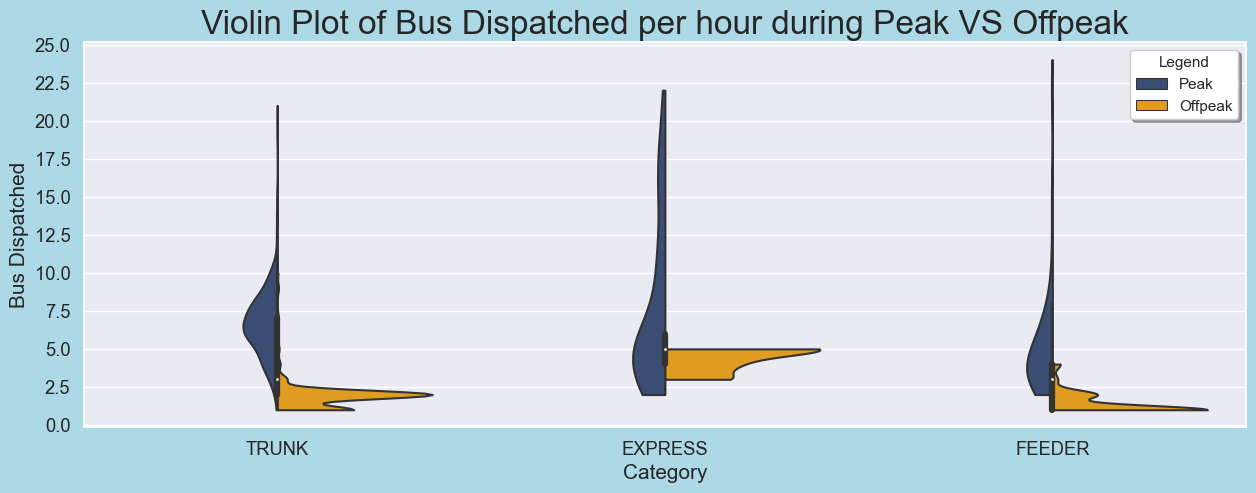

In [240]:
df = bus.copy()

# Group by routes
df = df.groupby(['ServiceNo','Direction']).agg({'AM_Peak_avg':'mean','PM_Peak_avg':'mean','AM_Offpeak_avg':'mean','PM_Offpeak_avg':'mean', 'Category':'first'}).reset_index()

# Convert it to bus dispatched per hour instead of total bus dispatched
df['Peak_Dispatch'] = (df['AM_Peak_avg'] + df['PM_Peak_avg'])//(3)
df['Offpeak_Dispatch'] = (df['AM_Offpeak_avg'] + df['PM_Offpeak_avg'])//(11)

df = df[['ServiceNo','Direction','Category','Peak_Dispatch','Offpeak_Dispatch']]

# Dropna
df = df.dropna()

# Convert from wide to long
df = pd.melt(df, id_vars=['ServiceNo','Direction','Category'], value_vars=['Peak_Dispatch','Offpeak_Dispatch'], var_name='Peak', value_name='Dispatch')
# Drop all 0
df = df[df['Dispatch']!=0]

# Plot Graph
fig, ax = plt.subplots(figsize=(15,5))

sns.violinplot(x='Category', y='Dispatch', data=df, hue='Peak', cut=0, split=True, palette=sns.color_palette(["#2f4b7c", "#ffa600"]), ax=ax)

# Edit the style
sns.set(style="darkgrid", rc={'figure.facecolor':'lightblue'}, font_scale=1.2)

# Edit the legend
ax.legend(loc='upper right', title='Legend', title_fontsize=11, fontsize=11, shadow=True, facecolor='white')

# Edit legend values
ax.get_legend().get_texts()[0].set_text('Peak')
ax.get_legend().get_texts()[1].set_text('Offpeak')

# Edit x and y labels
ax.set_xlabel('Category', fontsize=15)
ax.set_ylabel('Bus Dispatched', fontsize=15)

# Edit y axis
ax.set_yticks(np.arange(0, 26, 2.5))

# Edit the title
ax.set_title('Violin Plot of Bus Dispatched per hour during Peak VS Offpeak', fontsize=24)

# Offpeak not lot of bus for express and feeder (with 0 being the mode)
# This suggest that express and feeder are not dispatched as much during offpeak

plt.show()

### Chart 2
Reg Plot during different time (AM Peak, PM Peak, AM Offpeak, PM Offpeak) between total number of ridership per route (sum of tap in) and number of bus dispatched

In [246]:
# df = bus.copy()
# ridership = df.groupby(['ServiceNo', 'Direction']).sum()

# # Dispatch is the number of bus dispatched for entire day
# # Ridership is the number of people that board the bus per hour

# # convert to dispatch per hour

# ridership = ridership[['Weekday_Monthly_TapIn_AM_Peak', 'Weekend/Hols_Monthly_TapIn_AM_Peak', 'Weekday_Monthly_TapIn_AM_Offpeak', 'Weekend/Hols_Monthly_TapIn_AM_Offpeak', 'Weekday_Monthly_TapIn_PM_Peak', 'Weekend/Hols_Monthly_TapIn_PM_Peak', 'Weekday_Monthly_TapIn_PM_Offpeak', 'Weekend/Hols_Monthly_TapIn_PM_Offpeak', 'Weekday_Monthly_TapOut_AM_Peak', 'Weekend/Hols_Monthly_TapOut_AM_Peak', 'Weekday_Monthly_TapOut_AM_Offpeak', 'Weekend/Hols_Monthly_TapOut_AM_Offpeak', 'Weekday_Monthly_TapOut_PM_Peak', 'Weekend/Hols_Monthly_TapOut_PM_Peak', 'Weekday_Monthly_TapOut_PM_Offpeak', 'Weekend/Hols_Monthly_TapOut_PM_Offpeak']]

# ridership['Peak_Ridership'] = ridership['Weekday_Monthly_TapIn_AM_Peak'] + ridership['Weekend/Hols_Monthly_TapIn_AM_Peak'] + ridership['Weekday_Monthly_TapIn_PM_Peak'] + ridership['Weekend/Hols_Monthly_TapIn_PM_Peak']
# ridership['Offpeak_Ridership'] = ridership['Weekday_Monthly_TapIn_AM_Offpeak'] + ridership['Weekend/Hols_Monthly_TapIn_AM_Offpeak'] + ridership['Weekday_Monthly_TapIn_PM_Offpeak'] + ridership['Weekend/Hols_Monthly_TapIn_PM_Offpeak']
# ridership[['Peak_Ridership', 'Offpeak_Ridership']] = ridership[['Peak_Ridership', 'Offpeak_Ridership']].astype(int)

# ridership = ridership[['Peak_Ridership', 'Offpeak_Ridership']]

# dispatch = df.groupby(['ServiceNo', 'Direction']).first()

# dispatch['Peak_Dispatch'] = (dispatch['AM_Peak_avg'] + dispatch['PM_Peak_avg'])//(5)
# dispatch['Offpeak_Dispatch'] = (dispatch['AM_Offpeak_avg'] + dispatch['PM_Offpeak_avg'])//(11)
# dispatch[['Peak_Dispatch', 'Offpeak_Dispatch']] = dispatch[['Peak_Dispatch', 'Offpeak_Dispatch']].astype(int)

# dispatch = dispatch[['Category', 'Peak_Dispatch', 'Offpeak_Dispatch']]

# # Merge the two df based on index
# df = pd.merge(ridership, dispatch, left_index=True, right_index=True)

# # Clean data and remove outliers
# df = df[(df['Peak_Ridership'] != 0) & (df['Offpeak_Ridership'] != 0)]
# df = df[(df['Peak_Dispatch'] != 0) & (df['Offpeak_Dispatch'] != 0)]

# # df.loc[(df['Category'] == 'TRUNK') & (df['Peak_Ridership'] > 50000), 'Peak_Dispatch'] = df['Peak_Dispatch'] * 2
# # df.loc[(df['Category'] == 'TRUNK') & (df['Peak_Ridership'] < 10000), 'Peak_Dispatch'] = df['Peak_Dispatch'] * 0.5
# # df.loc[(df['Category'] == 'TRUNK') & (df['Offpeak_Ridership'] > 50000), 'Offpeak_Dispatch'] = df['Offpeak_Dispatch'] * 1.8

# q1 = df['Peak_Dispatch'].quantile(0.25)
# q3 = df['Peak_Dispatch'].quantile(0.75)
# iqr = q3 - q1
# df = df[(df['Peak_Dispatch'] >= q1 - 3*iqr) & (df['Peak_Dispatch'] <= q3 + 3*iqr)]
# q1 = df['Offpeak_Dispatch'].quantile(0.25)
# q3 = df['Offpeak_Dispatch'].quantile(0.75)
# iqr = q3 - q1
# df = df[(df['Offpeak_Dispatch'] >= q1 - 3*iqr) & (df['Offpeak_Dispatch'] <= q3 + 3*iqr)]

# display(df)

Peak_Ridership  Offpeak_Ridership Category  \
ServiceNo Direction                                               
10        1                  127750              81961    TRUNK   
          2                  126207              85259    TRUNK   
100       1                  129095              87619    TRUNK   
          2                  145030             100466    TRUNK   
101       1                   99943              88068    TRUNK   
...                             ...                ...      ...   
99        1                  114130              72258    TRUNK   
          2                  138154              79468    TRUNK   
990       1                   82624              49085    TRUNK   
991       1                   42941              35482    TRUNK   
          2                   59295              43833    TRUNK   

                     Peak_Dispatch  Offpeak_Dispatch  
ServiceNo Direction                                   
10        1                      4                 2  
          2                      4                 2  
100       1                      3                 2  
          2                      3                 2  
101       1                      3                 1  
...                            ...               ...  
99        1                      2                 1  
          2                      2                 1  
990       1                      4                 2  
991       1                      4                 2  
          2                      4                 2  

[486 rows x 5 columns]

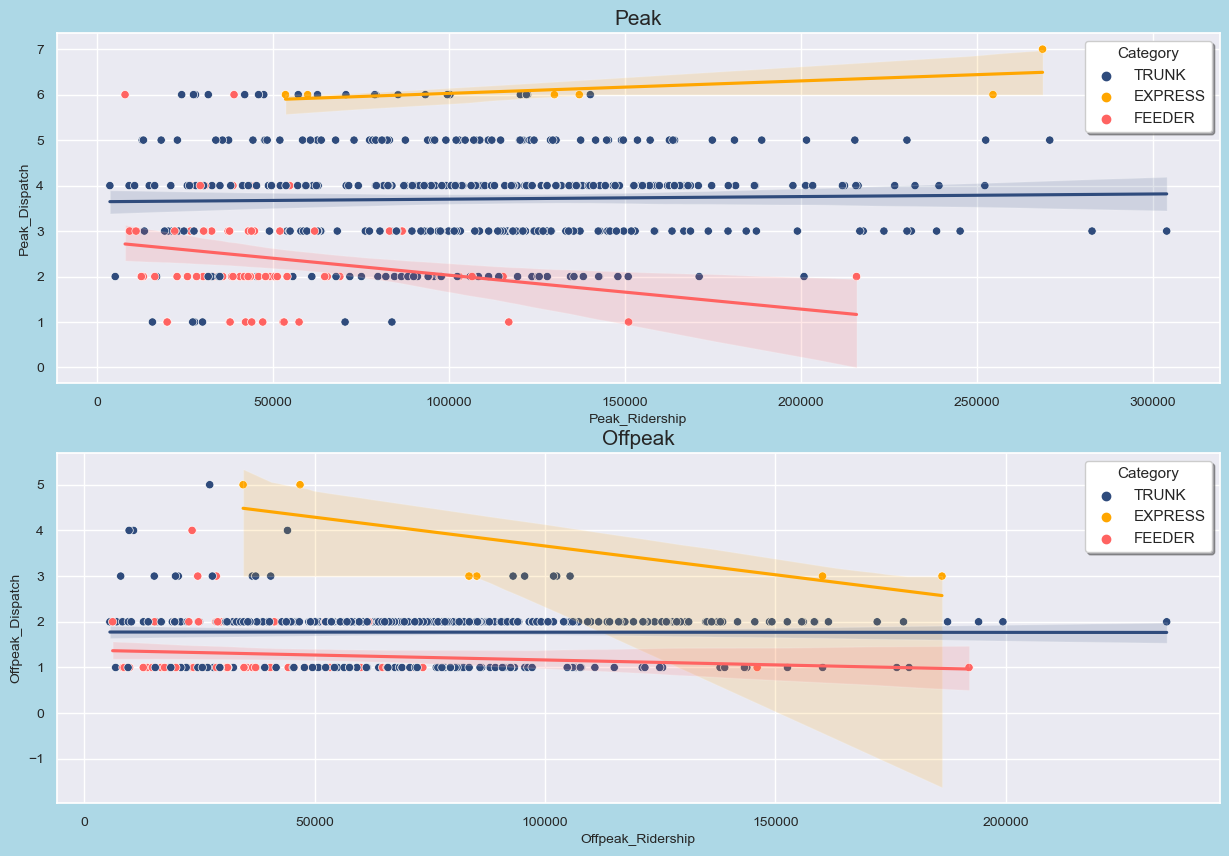

In [257]:
# # Plot a seaborn scatterplot of ridership vs dispatch at peak and offpeak
# fig, ax = plt.subplots(2, figsize=(15,10))

# sns.scatterplot(data=df, x='Peak_Ridership', y='Peak_Dispatch', hue='Category', palette=sns.color_palette(["#2f4b7c", "#ffa600", "#ff6361"]), ax=ax[0])
# sns.scatterplot(data=df, x='Offpeak_Ridership', y='Offpeak_Dispatch', hue='Category', palette=sns.color_palette(["#2f4b7c", "#ffa600", "#ff6361"]), ax=ax[1])

# # Edit the style
# sns.set(style="darkgrid", rc={'figure.facecolor':'lightblue'}, font_scale=1.2)

# # Edit x and y labels
# ax[0].set_xlabel('Ridership', fontsize=10)
# ax[0].set_ylabel('Dispatch', fontsize=10)
# ax[1].set_xlabel('Ridership', fontsize=10)
# ax[1].set_ylabel('Dispatch', fontsize=10)

# # Edit the title
# ax[0].set_title('Peak', fontsize=15)
# ax[1].set_title('Offpeak', fontsize=15)

# # Edit the tick labels
# ax[0].tick_params(axis='both', which='major', labelsize=10)
# ax[1].tick_params(axis='both', which='major', labelsize=10)

# # Plot the regression line for each category
# sns.regplot(x='Peak_Ridership', y='Peak_Dispatch', data=df[df['Category'] == 'EXPRESS'], ax=ax[0], scatter=False, color='#ffa600')
# sns.regplot(x='Offpeak_Ridership', y='Offpeak_Dispatch', data=df[df['Category'] == 'EXPRESS'], ax=ax[1], scatter=False, color='#ffa600')

# sns.regplot(x='Peak_Ridership', y='Peak_Dispatch', data=df[df['Category'] == 'TRUNK'], ax=ax[0], scatter=False, color='#2f4b7c')
# sns.regplot(x='Offpeak_Ridership', y='Offpeak_Dispatch', data=df[df['Category'] == 'TRUNK'], ax=ax[1], scatter=False, color='#2f4b7c')

# sns.regplot(x='Peak_Ridership', y='Peak_Dispatch', data=df[df['Category'] == 'FEEDER'], ax=ax[0], scatter=False, color='#ff6361')
# sns.regplot(x='Offpeak_Ridership', y='Offpeak_Dispatch', data=df[df['Category'] == 'FEEDER'], ax=ax[1], scatter=False, color='#ff6361')

# ax[0].legend(loc='upper right', title='Category', title_fontsize=11, fontsize=11, shadow=True, facecolor='white')
# ax[1].legend(loc='upper right', title='Category', title_fontsize=11, fontsize=11, shadow=True, facecolor='white')


# plt.show()

### Chart 2

In [243]:
df = bus.copy()
display(list(df.columns), df.head())

['ServiceNo',
 'Direction',
 'StopSequence',
 'Operator',
 'BusStopCode',
 'Distance',
 'RoadName',
 'Description',
 'Latitude',
 'Longitude',
 'Category',
 'OriginCode',
 'DestinationCode',
 'LoopDesc',
 'AM_Peak_avg',
 'AM_Offpeak_avg',
 'PM_Peak_avg',
 'PM_Offpeak_avg',
 'Weekday_Monthly_TapIn_AM_Peak',
 'Weekend/Hols_Monthly_TapIn_AM_Peak',
 'Weekday_Monthly_TapIn_AM_Offpeak',
 'Weekend/Hols_Monthly_TapIn_AM_Offpeak',
 'Weekday_Monthly_TapIn_PM_Peak',
 'Weekend/Hols_Monthly_TapIn_PM_Peak',
 'Weekday_Monthly_TapIn_PM_Offpeak',
 'Weekend/Hols_Monthly_TapIn_PM_Offpeak',
 'Weekday_Monthly_TapOut_AM_Peak',
 'Weekend/Hols_Monthly_TapOut_AM_Peak',
 'Weekday_Monthly_TapOut_AM_Offpeak',
 'Weekend/Hols_Monthly_TapOut_AM_Offpeak',
 'Weekday_Monthly_TapOut_PM_Peak',
 'Weekend/Hols_Monthly_TapOut_PM_Peak',
 'Weekday_Monthly_TapOut_PM_Offpeak',
 'Weekend/Hols_Monthly_TapOut_PM_Offpeak']

,ServiceNo,Direction,StopSequence,Operator,BusStopCode,Distance,RoadName,Description,Latitude,Longitude,...,Weekday_Monthly_TapIn_PM_Offpeak,Weekend/Hols_Monthly_TapIn_PM_Offpeak,Weekday_Monthly_TapOut_AM_Peak,Weekend/Hols_Monthly_TapOut_AM_Peak,Weekday_Monthly_TapOut_AM_Offpeak,Weekend/Hols_Monthly_TapOut_AM_Offpeak,Weekday_Monthly_TapOut_PM_Peak,Weekend/Hols_Monthly_TapOut_PM_Peak,Weekday_Monthly_TapOut_PM_Offpeak,Weekend/Hols_Monthly_TapOut_PM_Offpeak
0,10,1,1,SBST,75009,0.0,Tampines Ctrl 1,Tampines Int,1.354076,103.943391,...,1088.0,633.0,0.0,0.0,0.0,0.0,0.0,0.0,374.0,448.0
1,10,1,2,SBST,76059,0.6,Tampines Ave 5,Opp Our Tampines Hub,1.352962,103.941652,...,1645.0,526.0,1621.0,369.0,1184.0,562.0,979.0,482.0,240.0,84.0
2,10,1,3,SBST,76069,1.1,Tampines Ave 5,Blk 147,1.348753,103.942086,...,1014.0,318.0,1838.0,563.0,1552.0,662.0,1828.0,652.0,788.0,224.0
3,10,1,4,SBST,96289,2.3,Simei Ave,Changi General Hosp,1.340055,103.948381,...,522.0,195.0,0.0,933.0,1653.0,624.0,1989.0,797.0,503.0,205.0
4,10,1,5,SBST,96109,2.7,Simei Ave,Opp Blk 3012,1.337371,103.950673,...,131.0,60.0,1641.0,341.0,728.0,226.0,620.0,196.0,181.0,72.0


### Chart 3
Heatmap of Tap In to Tap Out ratio at different bus stops in Singapore during different time

In [244]:
df = bus.copy()

df['Weekday_Peak_Ratio'] = ((df['Weekday_Monthly_TapIn_AM_Peak']/df['Weekday_Monthly_TapOut_AM_Peak'])*3 + (df['Weekday_Monthly_TapIn_PM_Peak']/df['Weekday_Monthly_TapOut_PM_Peak'])*2)/5
df['Weekday_OffPeak_Ratio'] = ((df['Weekday_Monthly_TapIn_AM_Offpeak']/df['Weekday_Monthly_TapOut_AM_Offpeak'])*8 + (df['Weekday_Monthly_TapIn_PM_Offpeak']/df['Weekday_Monthly_TapOut_PM_Offpeak'])*10)/18
df['Weekend/Hols_Peak_Ratio'] = ((df['Weekend/Hols_Monthly_TapIn_AM_Peak']/df['Weekend/Hols_Monthly_TapOut_AM_Peak'])*3 + (df['Weekend/Hols_Monthly_TapIn_PM_Peak']/df['Weekend/Hols_Monthly_TapOut_PM_Peak'])*2)/5
df['Weekend/Hols_OffPeak_Ratio'] = ((df['Weekend/Hols_Monthly_TapIn_AM_Offpeak']/df['Weekend/Hols_Monthly_TapOut_AM_Offpeak'])*8 + (df['Weekend/Hols_Monthly_TapIn_PM_Offpeak']/df['Weekend/Hols_Monthly_TapOut_PM_Offpeak'])*10)/18

df['Weekday_Peak_Ratio'] = df['Weekday_Peak_Ratio'].dropna()
# Drop outliers using IQR
q1 = df['Weekday_Peak_Ratio'].quantile(0.25)
q3 = df['Weekday_Peak_Ratio'].quantile(0.75)
iqr = q3 - q1
df = df[(df['Weekday_Peak_Ratio'] >= q1 - 1.5*iqr) & (df['Weekday_Peak_Ratio'] <= q3 + 1.5*iqr)]

df['Weekday_OffPeak_Ratio'] = df['Weekday_OffPeak_Ratio'].dropna()
# Drop outliers using IQR   
q1 = df['Weekday_OffPeak_Ratio'].quantile(0.25)
q3 = df['Weekday_OffPeak_Ratio'].quantile(0.75)
iqr = q3 - q1
df = df[(df['Weekday_OffPeak_Ratio'] >= q1 - 1.5*iqr) & (df['Weekday_OffPeak_Ratio'] <= q3 + 1.5*iqr)]

df['Weekend/Hols_Peak_Ratio'] = df['Weekend/Hols_Peak_Ratio'].dropna()
# Drop outliers using IQR
q1 = df['Weekend/Hols_Peak_Ratio'].quantile(0.25)
q3 = df['Weekend/Hols_Peak_Ratio'].quantile(0.75)
iqr = q3 - q1
df = df[(df['Weekend/Hols_Peak_Ratio'] >= q1 - 1.5*iqr) & (df['Weekend/Hols_Peak_Ratio'] <= q3 + 1.5*iqr)]

df['Weekend/Hols_OffPeak_Ratio'] = df['Weekend/Hols_OffPeak_Ratio'].dropna()
# Drop outliers using IQR
q1 = df['Weekend/Hols_OffPeak_Ratio'].quantile(0.25)
q3 = df['Weekend/Hols_OffPeak_Ratio'].quantile(0.75)
iqr = q3 - q1
df = df[(df['Weekend/Hols_OffPeak_Ratio'] >= q1 - 1.5*iqr) & (df['Weekend/Hols_OffPeak_Ratio'] <= q3 + 1.5*iqr)]

df = df[['Latitude','Longitude','Weekday_Peak_Ratio','Weekday_OffPeak_Ratio','Weekend/Hols_Peak_Ratio','Weekend/Hols_OffPeak_Ratio']]

bus_190 = bus[bus['ServiceNo']=='190']
bus_65 = bus[bus['ServiceNo']=='65']

In [245]:
# Create figure object
fig = go.Figure()

# Trace 1 - Density Heatmap
fig.add_trace(go.Densitymapbox(lat=df['Latitude'], lon=df['Longitude'], z=df['Weekday_Peak_Ratio'],
                                 radius=5, zmin = df['Weekday_Peak_Ratio'].min(), zmax = 8,
                                 colorscale='Viridis',colorbar={'title':'Ratio'},name='Ratio'))

# Trace 2 - Add bus route 65
fig.add_trace(go.Scattermapbox(
    lat=bus_65['Latitude'],
    lon=bus_65['Longitude'],
    mode='lines',
    line=dict(width=2, color='red'),
    name='Bus Route 65',
    showlegend=True,
    visible='legendonly'
))

# Trace 3 - Add bus route 190
fig.add_trace(go.Scattermapbox(
    lat=bus_190['Latitude'],
    lon=bus_190['Longitude'],
    mode='lines',
    line=dict(width=2, color='blue'),
    name='Bus Route 190',
    showlegend=True,
    visible='legendonly'
))

# Create layout
fig.update_layout(mapbox=dict(
                    accesstoken=mapbox_access_token,
                    # Light: carto-positron, Dark: carto-darkmatter
                    style="carto-positron",
                    center = dict(lat=df['Latitude'].mean(), lon=df['Longitude'].mean()),
                    zoom=10),
                  margin={"r":10,"t":0,"l":0,"b":0})

# Add title and subtitle
fig.update_layout(
    title={
        'text': "Tap In/Tap Out Ratio of Bus Stops",
        'y':0.98,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    titlefont=dict(
        size=30)
)


                

# Create menus
fig.update_layout(
    updatemenus=[
        # Add dropdown
        dict(
            buttons=list([
                dict(
                    args=[{'z': [df["Weekday_Peak_Ratio"]]}],
                    label="Tap In/Tap Out Ratio during Weekday Peak hours",
                    method="restyle"
                ),
                dict(
                    args=[{'z': [df["Weekday_OffPeak_Ratio"]]}],
                    label='Tap In/Tap Out Ratio during Weekday Offpeak hours',
                    method="restyle"
                ),
                dict(
                    args=[{'z': [df["Weekend/Hols_Peak_Ratio"]]}],
                    label='Tap In/Tap Out Ratio during Public Holiday Peak Hours',
                    method="restyle"
                ),
                dict(
                    args=[{'z': [df['Weekend/Hols_OffPeak_Ratio']]}],
                    label='Tap In/Tap Out Ratio during Public Holiday Offpeak Hours',
                    method="restyle"
                )
            ]),
            direction="down",
            pad={"r": 10, "t": 0},
            showactive=True,
            x=0,
            xanchor="left",
            y=1.1,
            yanchor="top"
        ),
        # Buttons for bus routes
        dict(
            type="buttons",
            buttons=list([
                # First button for neither bus routes
                dict(
                    args=[{'visible':'legendonly'},[1,2]],
                    label='None',
                    method="restyle"
                ),
                # Second button for bus route 65
                dict(
                    args=[{'visible':True},[1]],
                    args2=[{'visible':'legendonly'},[1]],
                    label="Bus Route 65",
                    method="restyle"
                ),
                # Third button for bus route 190
                dict(
                    args=[{'visible':True},[2]],
                    args2=[{'visible':'legendonly'},[2]],
                    label='Bus Route 190',
                    method="restyle"
                ),
                # Fourth button for both bus routes
                dict(
                    args=[{'visible':True},[1,2]],
                    args2=[{'visible':'legendonly'},[1,2]],
                    label="Both Bus Routes",
                    method="restyle"
                )
            ]),
            direction="right",
            pad={"r": 30, "t": 0},
            showactive=True,
            x=0.38,
            xanchor="left",
            y=1.1,
            yanchor="top"
        )
    ]
)

# Make legends not overlap
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.15,
    xanchor="right",
    x=1.1
))

fig.show()
# An explanation of the plot is found in chart3.md